# Desafio Data Science Semana 3

## Preparando os dados para o Machine Learning

In [1]:
import pandas as pd
import seaborn as sns
from  matplotlib import pyplot as plt
from utils import SEED, executa_modelo, gera_matriz_confusao, otimiza_modelo
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
%matplotlib inline
pd.set_option("display.max_columns", 50)
dados = pd.read_csv('Dados/dados_tratados.csv')

In [3]:
# convertendo valores das colunas categóricas para valores inteiros
# vou considerar 0 para o valor sem internet e sem telefone (mesmo que não)
replace_columns = {
    'Não': 0,
    'Sim': 1,
    'Feminino': 0,
    'Masculino': 1,
    'Sem internet': 0,
    'Sem telefone': 0
}
dados = dados.replace(replace_columns)

In [4]:
# removendo colunas desnecessárias
# a coluna id do cliente possui valores únicos não sendo interessante para treinar o modelo
# a coluna valor total pode ser obtida com o produto de meses de contrato e valor por mês
# o mesmo ocorre com gastos diários
dados = dados.drop(columns=['Id Cliente', 'Valor total', 'Gastos diários'])
dados.head()

,Cancelado,Gênero,Maior igual a 65,Parceiro,Dependentes,Meses de contrato,Serviço telefônico,Múltiplas linhas,Serviço de internet,Segurança online,Backup online,Proteção do dispositivo,Suporte técnico,TV a cabo,Streaming de filmes,Tipo de contrato,Fatura online,Forma de pagamento,Valor por mês
0,0,0,0,1,1,9,1,0,DSL,0,1,0,1,1,0,Anual,1,Cheque enviado,65.6
1,0,1,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Mensal,0,Cheque enviado,59.9
2,1,1,0,0,0,4,1,0,Fibra Ótica,0,0,1,0,0,0,Mensal,1,Cheque eletrônico,73.9
3,1,1,1,1,0,13,1,0,Fibra Ótica,0,1,1,0,1,1,Mensal,1,Cheque eletrônico,98.0
4,1,0,1,1,0,3,1,0,Fibra Ótica,0,0,0,1,1,0,Mensal,1,Cheque enviado,83.9


### A técnica one-hot encoding consiste em transformar valores categóricos em colunas binárias

In [5]:
# one-hot encoding nas colunas Serviço de internet, tipo de contrato e forma de pagamento
dados = pd.get_dummies(columns=['Serviço de internet', 'Tipo de contrato', 'Forma de pagamento'],
                        data=dados)
dados.head()

,Cancelado,Gênero,Maior igual a 65,Parceiro,Dependentes,Meses de contrato,Serviço telefônico,Múltiplas linhas,Segurança online,Backup online,Proteção do dispositivo,Suporte técnico,TV a cabo,Streaming de filmes,Fatura online,Valor por mês,Serviço de internet_0,Serviço de internet_DSL,Serviço de internet_Fibra Ótica,Tipo de contrato_2 anos,Tipo de contrato_Anual,Tipo de contrato_Mensal,Forma de pagamento_Cartão de crédito,Forma de pagamento_Cheque eletrônico,Forma de pagamento_Cheque enviado,Forma de pagamento_Transferência bancária
0,0,0,0,1,1,9,1,0,0,1,0,1,1,0,1,65.6,0,1,0,0,1,0,0,0,1,0
1,0,1,0,0,0,9,1,1,0,0,0,0,0,1,0,59.9,0,1,0,0,0,1,0,0,1,0
2,1,1,0,0,0,4,1,0,0,0,1,0,0,0,1,73.9,0,0,1,0,0,1,0,1,0,0
3,1,1,1,1,0,13,1,0,0,1,1,0,1,1,1,98.0,0,0,1,0,0,1,0,1,0,0
4,1,0,1,1,0,3,1,0,0,0,0,1,1,0,1,83.9,0,0,1,0,0,1,0,0,1,0


In [6]:
dados.shape

(7043, 26)

### Balanceamento dos dados

In [7]:
dados.Cancelado.value_counts()

0    5174
1    1869
Name: Cancelado, dtype: int64

In [8]:
# os dados estão desbalanceados, ou seja, existem 5174 clientes ativos e 1869 clientes 
# que cancelaram o plano. Para balancear os dados vamos utilizar a técnica SMOTE.
x = dados.drop(['Cancelado'], axis=1)
y = dados['Cancelado']
sm = SMOTE(random_state=SEED)
res_x, res_y = sm.fit_resample(x, y)
dados_balanceados = pd.concat([res_y, res_x], axis=1)

In [9]:
dados_balanceados.Cancelado.value_counts()

0    5174
1    5174
Name: Cancelado, dtype: int64

## Treinando e testando o modelo

In [10]:
# definindo dados de treino e teste
x = dados_balanceados.drop(['Cancelado'], axis=1)
y = dados_balanceados['Cancelado']
# separa os dados em treino e teste
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size= 0.3, random_state= SEED)
print('Base de treino tem %d elementos e a base de teste tem %d elementos' % (treino_x.shape[0], teste_x.shape[0]))

Base de treino tem 7243 elementos e a base de teste tem 3105 elementos


As seguintes métricas são importantes na análise do melhor modelo de machine learning:
* Acurácia: avalia a proporção de acertos em relação a todas as previsões realizadas.
* Precisão: avalia a proporção de verdadeiros positivos dentre as predições dadas como positivas pelo modelo.
* Sensibilidade ou Recall: avalia a proporção de verdadeiros positivos dentre todos os valores positivos reais.
* F1 Score: é o equilíbrio entre a sensibilidade e a precisão, sendo a média harmônica entre as duas métricas.

In [11]:
# classificador SVC
parametros_modelo={
    'random_state': SEED
}
metricas_svc, previsao_svc = executa_modelo(treino_x, teste_x, treino_y, teste_y, SVC, parametros_modelo)

Matriz de confusão


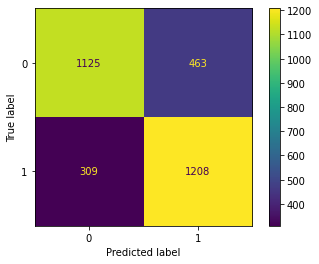

In [12]:
gera_matriz_confusao(teste_y, previsao_svc)

In [13]:
# classificador árvore de decisão
parametros_modelo.update({'max_depth': 10})
metricas_dt, previsao_dt = executa_modelo(treino_x, teste_x, treino_y, teste_y, DecisionTreeClassifier, parametros_modelo)

Matriz de confusão


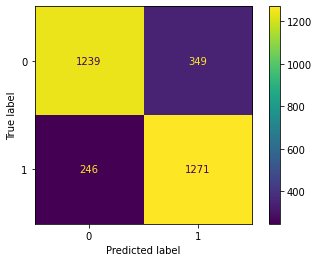

In [14]:
gera_matriz_confusao(teste_y, previsao_dt)

In [15]:
# classificador floresta aleatória
metricas_rf, previsao_rf = executa_modelo(treino_x, teste_x, treino_y, teste_y, RandomForestClassifier, parametros_modelo)

Matriz de confusão


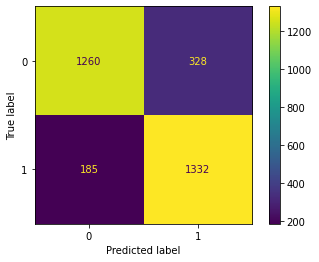

In [16]:
gera_matriz_confusao(teste_y, previsao_rf)

In [17]:
# comparação das métricas dos modelos
dicionario_modelos = metricas_svc | metricas_dt | metricas_rf
comparacao_modelos = pd.DataFrame(dicionario_modelos).T
comparacao_modelos = comparacao_modelos.reset_index().rename(columns={'index': 'Modelo'})
comparacao_modelos

,Modelo,Acurácia,Precisão,Recall,F1 score
0,SVC,0.751369,0.722920,0.796309,0.757842
1,DecisionTreeClassifier,0.808374,0.784568,0.837838,0.810328
2,RandomForestClassifier,0.834783,0.802410,0.878049,0.838527


O modelo que escolhi entre os três é o Random Forest porque obteve o maior recall. Esta métrica permite verificar o quanto o modelo errou em relação aos clientes que cancelaram. 

# Otimizando o modelo

In [18]:
busca = otimiza_modelo(x, y)
busca.best_params_

{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 9,
 'criterion': 'entropy',
 'bootstrap': False}

In [19]:
scores = cross_val_score(busca.best_estimator_, x, y, scoring = 'recall', 
                        cv = KFold(n_splits = 5, shuffle=True))

In [20]:
scores.mean()

0.8821624482809108

In [23]:
# depois de definir os melhores hiper parâmetros treina o modelo novamente
parametros_modelo = busca.best_params_
parametros_modelo.update(random_state = SEED)
metricas_rf, previsao_rf = executa_modelo(treino_x, teste_x, treino_y, teste_y, RandomForestClassifier, parametros_modelo)

In [24]:
metricas_rf

{'RandomForestClassifier': {'Acurácia': 0.8260869565217391,
  'Precisão': 0.7892243931320307,
  'Recall': 0.8787079762689519,
  'F1 score': 0.8315658140985652}}

A pesquisa com RandomizedSearchCV não trouxe melhoria para o modelo. Aumentar o espaço de pesquisa por melhores parâmetros incorre em maior custo computacional e não era o objetivo deste trabalho. 